# Analyse du dataset d'histoire olympique

Pour cette analyse, j'ai utilisé le dataset "120 ans d'histoire olympique", qui répertorie tous les compétiteurs à chaque compétition olympique depuis 1900. Le dataset contient des informations telles que le pays de naissance de chaque compétiteur, s'ils ont obtenu une médaille, etc. que vous pouvez télécharger et lire la description sur le lien ci-dessous 
    - https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results#athlete_events.csv

# Préparation des Données

- Une fois le jeu de données téléchargé, 
- Je l'ai déposé dans le cloud GCP. 
- Ensuite, j'ai créé un répertoire dans HDFS avec la commande suivante 
    - hdfs dfs -mkdir /app
- J'ai ensuite déposé le fichier CSV dans le répertoire HDFS avec la commande :
    - hdfs dfs -put athlete_events.csv /app/data.csv

# Analyse Complète des Top 10 Meilleurs Pays

J'ai effectué une analyse complète des 10 meilleurs pays en termes de médailles, en incluant le nombre total de médailles (or, argent, bronze). Des visualisations ont également été créées en utilisant les bibliothèques Seaborn, Matplotlib et Pandas

# Création de la Base de Données et de la Table dans Hive

- Afin de réaliser cette analyse sur le jeu de données, 
- j'ai commencé par créer la base de données et la table dans Hive.

In [217]:
from pyhive import hive

# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Création d'une base de données   
database_name = "bigdata_athlete"

# Création de la requête SQL pour créer la base de données
create_database_query = f"CREATE DATABASE IF NOT EXISTS {database_name}"

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(create_database_query)

# Fermeture de la connexion
conn.close()

print(f"La base de données {database_name} a été créée avec succès.")

La base de données bigdata_athlete a été créée avec succès.


# Création de la table 

In [218]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Nom de la table
table_name = f"{database_name}.tab3_athlete"

# Création de la requête SQL pour créer la table
create_table_query = f"""
CREATE TABLE IF NOT EXISTS {table_name} (
    ID BIGINT,
    Name STRING,
    Sex CHAR(3),
    Age INT,
    Height INT,
    Weight INT,
    Team STRING,
    NOC STRING,
    Games STRING,
    Year INT,
    Season STRING,
    City STRING,
    Sport STRING,
    Event STRING,
    Medal STRING
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION '/app/master_bigdata/'
TBLPROPERTIES ("skip.header.line.count"="1")
"""

# Exécution de la requête de création de table
with conn.cursor() as cursor:
    cursor.execute(create_table_query)
    
# Fermeture de la connexion
conn.close()
print(f"La table {table_name} a été créée avec succès.")

La table bigdata_athlete.tab3_athlete a été créée avec succès.


In [219]:
import pandas as pd

# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")


# Nom de la table
table_name = f"{database_name}.tab3_athlete"

# Requête Hive pour sélectionner toutes les lignes de la table
select_query = f"SELECT * FROM {table_name}"

# Exécution de la requête SELECT
with conn.cursor() as cursor:
    cursor.execute(select_query)

    # Récupération des résultats dans un DataFrame pandas
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])


# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df.head()

,tab3_athlete.id,tab3_athlete.name,tab3_athlete.sex,tab3_athlete.age,tab3_athlete.height,tab3_athlete.weight,tab3_athlete.team,tab3_athlete.noc,tab3_athlete.games,tab3_athlete.year,tab3_athlete.season,tab3_athlete.city,tab3_athlete.sport,tab3_athlete.event,tab3_athlete.medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992.0,Summer,Barcelona,Basketball,Basketball Men's Basketball,NA
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012.0,Summer,London,Judo,Judo Men's Extra-Lightweight,NA
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920.0,Summer,Antwerpen,Football,Football Men's Football,NA
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900.0,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988.0,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NA


# Analyses

## Analyse de la Moyenne du Poids et de la Taille par Sexe
- J'ai effectué une analyse de la moyenne du poids et de la Taille par Sexe avec la fréquence d'occurrence de chaque sexe.

In [220]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Sex,
    AVG(Weight) AS AverageWeight,
    COUNT(*) AS Frequency
FROM
    (SELECT Sex, Weight
     FROM {table_name}
     WHERE Sex IN ('F', 'M') AND Weight IS NOT NULL) subquery
GROUP BY Sex
ORDER BY Sex
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,sex,averageweight,frequency
0,F,60.040751,65962
1,M,75.712669,140448


In [221]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Sex,
    AVG(Height) AS AverageHeight
FROM
    (SELECT Sex, Height
     FROM {table_name}
     WHERE Sex IN ('F', 'M') AND Height IS NOT NULL) subquery
GROUP BY Sex
ORDER BY Sex
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,sex,averageheight
0,F,167.845415
1,M,178.835103


## Distribution du Poids et de la Taille  par Sexe
- Ensuite, j'ai analysé la distribution du poids par sexe avec la fréquence d'occurrence de chaque poids.

In [223]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT Sex, Weight, COUNT(*) as Frequency
FROM {table_name}
WHERE Sex IN ('F', 'M') AND Weight IS NOT NULL
GROUP BY Sex, Weight
ORDER BY Sex, Weight
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df_Weight = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df_Weight.head()

,sex,weight,frequency
0,F,25,6
1,F,28,13
2,F,30,42
3,F,31,23
4,F,32,41


In [224]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT Sex, Height, COUNT(*) as Frequency
FROM {table_name}
WHERE Sex IN ('F', 'M') AND Height IS NOT NULL
GROUP BY Sex, Height
ORDER BY Sex, Height
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df_Height = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df_Height.head()

,sex,height,frequency
0,F,127,6
1,F,131,2
2,F,132,6
3,F,133,5
4,F,135,12


### La Visualisations de la Distribution du Poids et de la Taille par Sexe

- La visualisation ci-dessus illustre la distribution du poids et de la taille par sexe, avec la fréquence d'occurrence de chaque sexe. Il est clairement observable que le poids et la taille des hommes sont généralement plus élevés, suivis de près par ceux des femmes.

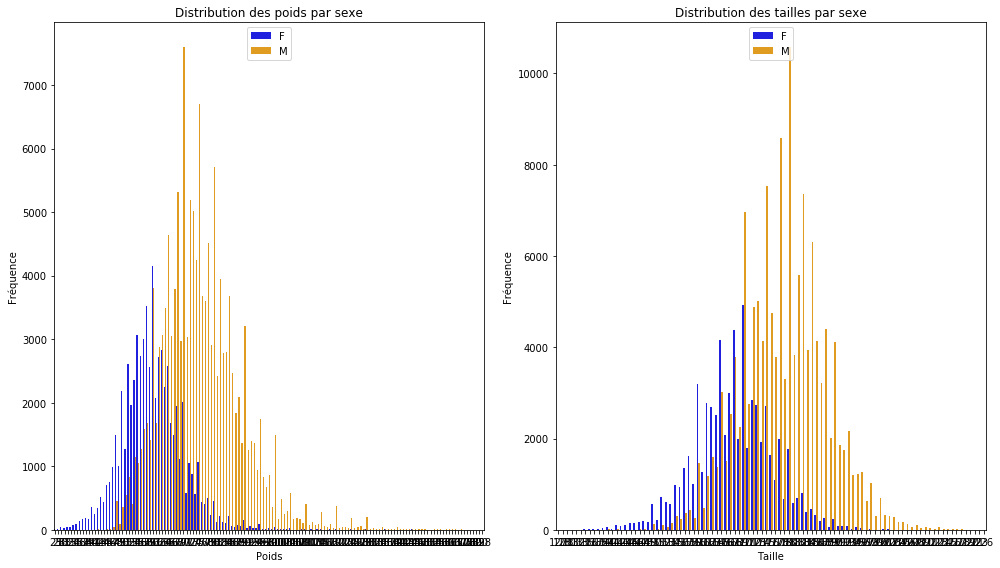

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supprimer les espaces supplémentaires dans la colonne 'sex'
df_Weight['sex'] = df_Weight['sex'].str.strip()
df_Height['sex'] = df_Height['sex'].str.strip()

# Créer un diagramme en barres empilées avec seaborn pour le poids
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
sns.barplot(x='weight', y='frequency', hue='sex', data=df_Weight, palette={'F': 'blue', 'M': 'orange'})
plt.xlabel('Poids')
plt.ylabel('Fréquence')
plt.title('Distribution des poids par sexe')
plt.legend()

# Créer un diagramme en barres empilées avec seaborn pour la taille
plt.subplot(1, 2, 2)
sns.barplot(x='height', y='frequency', hue='sex', data=df_Height, palette={'F': 'blue', 'M': 'orange'})
plt.xlabel('Taille')
plt.ylabel('Fréquence')
plt.title('Distribution des tailles par sexe')
plt.legend()

plt.tight_layout()
plt.show()

# Top 10 des Pays avec le Plus Grand Nombre de Médailles

### J'ai déterminé les 10 meilleurs pays en termes de vecteur des médailles

In [227]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Team,
    COUNT(*) AS TotalMedals
FROM
    {table_name}
WHERE
    Medal IN ('Gold', 'Silver', 'Bronze')
GROUP BY
    Team
ORDER BY
    TotalMedals DESC
LIMIT 10
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,team,totalmedals
0,United States,4190
1,Soviet Union,1963
2,Germany,1401
3,Great Britain,1245
4,Australia,1143
5,Canada,1117
6,Italy,966
7,Russia,921
8,Sweden,917
9,France,880


### Voici la visualisation des 10 meilleurs pays en termes de vecteur des médailles 

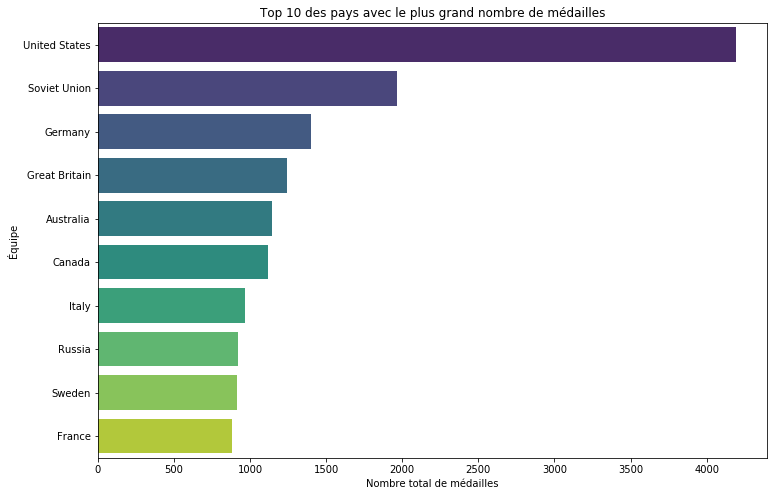

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un graphique à barres horizontales
plt.figure(figsize=(12, 8))
sns.barplot(x='totalmedals', y='team', data=df, palette='viridis')

# Ajouter des étiquettes et un titre
plt.xlabel("Nombre total de médailles")
plt.ylabel('Équipe')
plt.title("Top 10 des pays avec le plus grand nombre de médailles")

# Afficher le graphique
plt.show()

## Médailles d'Or

In [229]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Team,
    COUNT(*) AS Gold
FROM {table_name}
WHERE Medal = 'Gold'
GROUP BY Team
ORDER BY Gold DESC
LIMIT 10
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,team,gold
0,United States,2028
1,Soviet Union,813
2,Germany,430
3,Great Britain,417
4,Canada,401
5,East Germany,318
6,Italy,301
7,Russia,293
8,Australia,286
9,China,271


### Voici la visualisation de TOP 10 des pays ayant remporté le plus de médailles d'or.

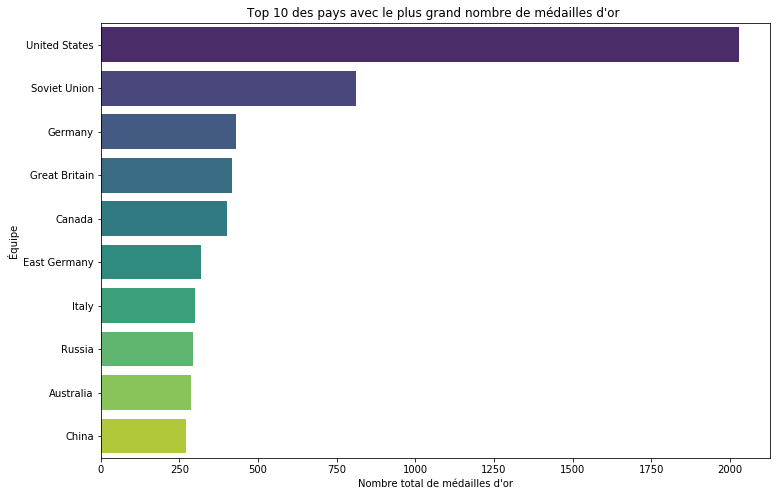

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un graphique à barres horizontales
plt.figure(figsize=(12, 8))
sns.barplot(x='gold', y='team', data=df, palette='viridis')

# Ajouter des étiquettes et un titre
plt.xlabel("Nombre total de médailles d'or")
plt.ylabel('Équipe')
plt.title("Top 10 des pays avec le plus grand nombre de médailles d'or ")

# Afficher le graphique
plt.show()

## Médailles d'Argent

In [231]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Team,
    COUNT(*) AS Silver
FROM {table_name}
WHERE Medal = 'Silver'
GROUP BY Team
ORDER BY Silver DESC
LIMIT 10
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,team,silver
0,United States,1221
1,Soviet Union,584
2,Germany,455
3,Australia,408
4,Great Britain,390
5,Canada,364
6,Sweden,319
7,France,316
8,Italy,311
9,Russia,297


### Voici la visualisation de Top 10 des pays ayant remporté le plus de médailles d'argent.

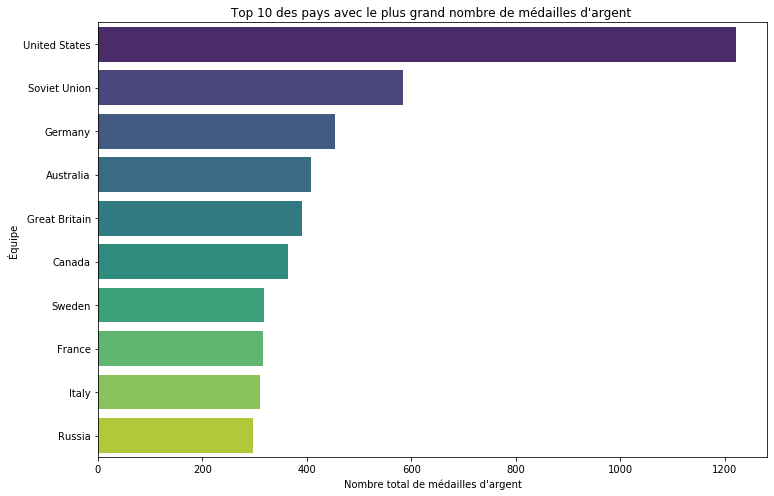

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un graphique à barres horizontales
plt.figure(figsize=(12, 8))
sns.barplot(x='silver', y='team', data=df, palette='viridis')

# Ajouter des étiquettes et un titre
plt.xlabel("Nombre total de médailles d'argent")
plt.ylabel('Équipe')
plt.title("Top 10 des pays avec le plus grand nombre de médailles d'argent ")

# Afficher le graphique
plt.show()

## Médailles de Bronze

In [233]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Team,
    COUNT(*) AS Bronze
FROM {table_name}
WHERE Medal = 'Bronze'
GROUP BY Team
ORDER BY Bronze DESC
LIMIT 10
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,team,bronze
0,United States,941
1,Soviet Union,566
2,Germany,516
3,Australia,449
4,Great Britain,438
5,Sweden,355
6,Italy,354
7,France,353
8,Canada,352
9,Finland,343


### Voici la visualisation de Top 10 des pays ayant remporté le plus de médailles de bronze

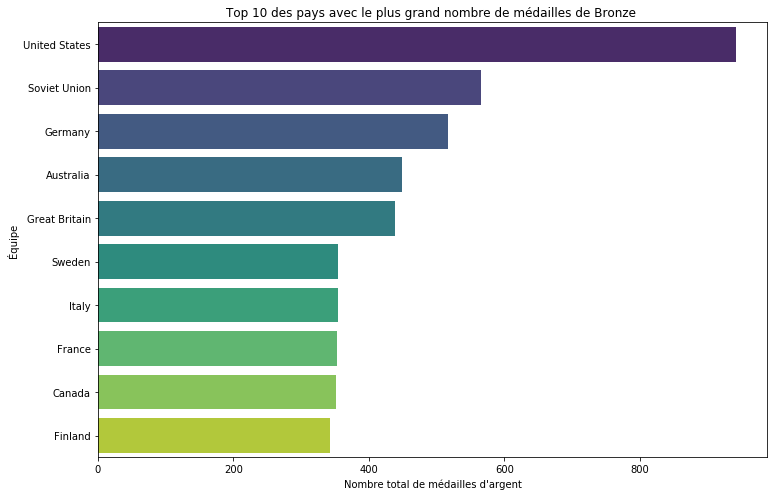

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un graphique à barres horizontales
plt.figure(figsize=(12, 8))
sns.barplot(x='bronze', y='team', data=df, palette='viridis')

# Ajouter des étiquettes et un titre
plt.xlabel("Nombre total de médailles d'argent")
plt.ylabel('Équipe')
plt.title("Top 10 des pays avec le plus grand nombre de médailles de Bronze ")


# Afficher le graphique
plt.show()

###### J'ai déterminé les 10 meilleurs pays en termes de vecteur des médailles, en prenant en compte toutes les médailles (or, argent, bronze).

In [235]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Team,
    COUNT(*) AS TotalMedals,
    SUM(CASE WHEN Medal = 'Gold' THEN 1 ELSE 0 END) AS Gold,
    SUM(CASE WHEN Medal = 'Silver' THEN 1 ELSE 0 END) AS Silver,
    SUM(CASE WHEN Medal = 'Bronze' THEN 1 ELSE 0 END) AS Bronze
FROM {table_name}
WHERE Medal IN ('Gold', 'Silver', 'Bronze')
GROUP BY Team
ORDER BY TotalMedals DESC
LIMIT 10
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,team,totalmedals,gold,silver,bronze
0,United States,4190,2028,1221,941
1,Soviet Union,1963,813,584,566
2,Germany,1401,430,455,516
3,Great Britain,1245,417,390,438
4,Australia,1143,286,408,449
5,Canada,1117,401,364,352
6,Italy,966,301,311,354
7,Russia,921,293,297,331
8,Sweden,917,243,319,355
9,France,880,211,316,353


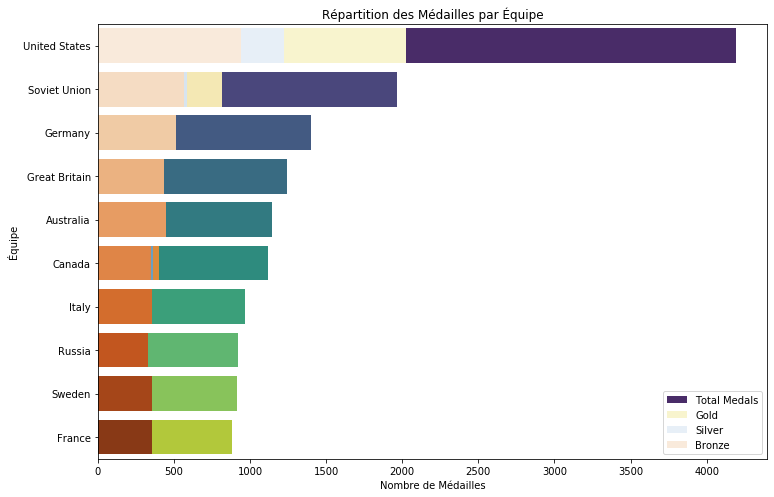

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un graphique à barres horizontales empilées
plt.figure(figsize=(12, 8))
sns.barplot(y='team', x='totalmedals', data=df, palette='viridis', label='Total Medals')
sns.barplot(y='team', x='gold', data=df, palette='YlOrBr', label='Gold')
sns.barplot(y='team', x='silver', data=df, palette='Blues', label='Silver')
sns.barplot(y='team', x='bronze', data=df, palette='Oranges', label='Bronze')

# Ajouter des étiquettes et un titre
plt.ylabel('Équipe')
plt.xlabel('Nombre de Médailles')
plt.title('Répartition des Médailles par Équipe')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

### On s'intéresse à présent au nombre de médailles remportées par sexe.

In [237]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Sex,
    COUNT(*) AS TotalMedals
FROM
    {table_name}
WHERE
    Medal IN ('Gold', 'Silver', 'Bronze')
GROUP BY
    Sex
ORDER BY
    TotalMedals DESC
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,sex,totalmedals
0,M,20989
1,F,9769


###### Le Nombre de médailles remportées par sexe en prenant en compte toutes les médailles (or, argent, bronze).

In [238]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Sex,
    COUNT(*) AS TotalMedals,
    SUM(CASE WHEN Medal = 'Gold' THEN 1 ELSE 0 END) AS Gold,
    SUM(CASE WHEN Medal = 'Silver' THEN 1 ELSE 0 END) AS Silver,
    SUM(CASE WHEN Medal = 'Bronze' THEN 1 ELSE 0 END) AS Bronze
FROM {table_name}
WHERE Medal IN ('Gold', 'Silver', 'Bronze')
GROUP BY Sex
ORDER BY TotalMedals DESC
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,sex,totalmedals,gold,silver,bronze
0,M,20989,6986,6909,7094
1,F,9769,3244,3229,3296


### Classement des 10 meilleurs pays masculins en termes de victoires médailles

In [239]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Team,
    Sex,
    COUNT(*) AS TotalMedals,
    SUM(CASE WHEN Medal = 'Gold' THEN 1 ELSE 0 END) AS Gold,
    SUM(CASE WHEN Medal = 'Silver' THEN 1 ELSE 0 END) AS Silver,
    SUM(CASE WHEN Medal = 'Bronze' THEN 1 ELSE 0 END) AS Bronze
FROM {table_name}
WHERE Medal IN ('Gold', 'Silver', 'Bronze') AND Sex IN ('M')
GROUP BY Team,Sex
ORDER BY TotalMedals DESC
LIMIT 10
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,team,sex,totalmedals,gold,silver,bronze
0,United States,M,2626,1267,750,609
1,Soviet Union,M,1386,563,432,391
2,Great Britain,M,939,337,304,298
3,Germany,M,888,283,298,307
4,Italy,M,818,267,253,298
5,Sweden,M,741,206,241,294
6,France,M,708,173,246,289
7,Canada,M,646,256,228,162
8,Australia,M,631,120,239,272
9,Japan,M,519,144,166,209


## Visualisation du classement masculin.

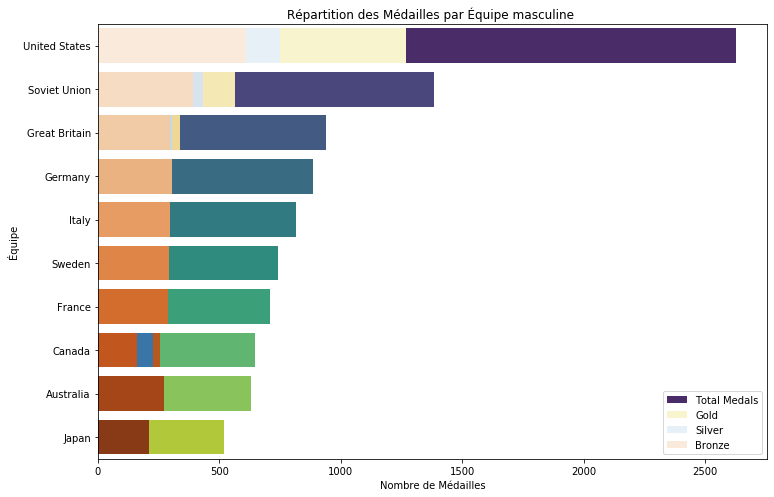

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un graphique à barres horizontales empilées
plt.figure(figsize=(12, 8))
sns.barplot(y='team', x='totalmedals', data=df, palette='viridis', label='Total Medals')
sns.barplot(y='team', x='gold', data=df, palette='YlOrBr', label='Gold')
sns.barplot(y='team', x='silver', data=df, palette='Blues', label='Silver')
sns.barplot(y='team', x='bronze', data=df, palette='Oranges', label='Bronze')

# Ajouter des étiquettes et un titre
plt.ylabel('Équipe')
plt.xlabel('Nombre de Médailles')
plt.title('Répartition des Médailles par Équipe masculine ')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

### Classement des 10 meilleurs pays féminins en termes de victoires médailles

In [241]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Team,
    Sex,
    COUNT(*) AS TotalMedals,
    SUM(CASE WHEN Medal = 'Gold' THEN 1 ELSE 0 END) AS Gold,
    SUM(CASE WHEN Medal = 'Silver' THEN 1 ELSE 0 END) AS Silver,
    SUM(CASE WHEN Medal = 'Bronze' THEN 1 ELSE 0 END) AS Bronze
FROM {table_name}
WHERE Medal IN ('Gold', 'Silver', 'Bronze') AND Sex IN ('F')
GROUP BY Team,Sex
ORDER BY TotalMedals DESC
LIMIT 10
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,team,sex,totalmedals,gold,silver,bronze
0,United States,F,1564,761,471,332
1,Soviet Union,F,577,250,152,175
2,China,F,549,167,219,163
3,Germany,F,513,147,157,209
4,Australia,F,512,166,169,177
5,Russia,F,476,179,161,136
6,Canada,F,471,145,136,190
7,Netherlands,F,378,124,124,130
8,East Germany,F,365,156,115,94
9,Great Britain,F,306,80,86,140


## Visualisation du classement féminin

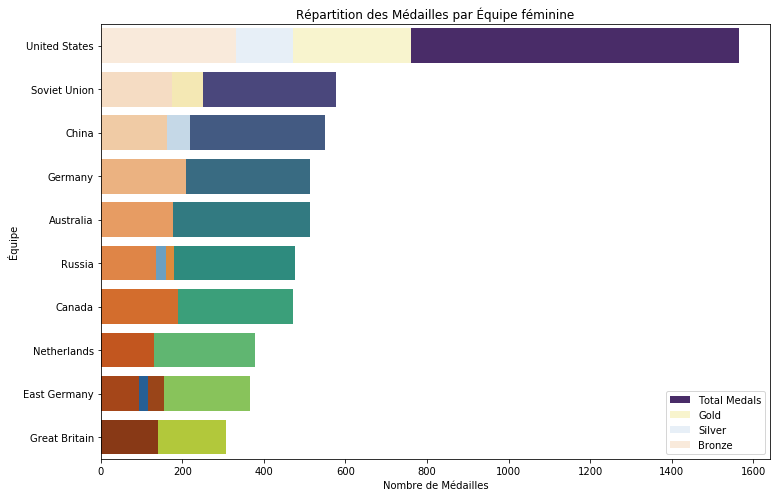

In [242]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un graphique à barres horizontales empilées
plt.figure(figsize=(12, 8))
sns.barplot(y='team', x='totalmedals', data=df, palette='viridis', label='Total Medals')
sns.barplot(y='team', x='gold', data=df, palette='YlOrBr', label='Gold')
sns.barplot(y='team', x='silver', data=df, palette='Blues', label='Silver')
sns.barplot(y='team', x='bronze', data=df, palette='Oranges', label='Bronze')

# Ajouter des étiquettes et un titre
plt.ylabel('Équipe')
plt.xlabel('Nombre de Médailles')
plt.title('Répartition des Médailles par Équipe féminine')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

### Les 10 sports les plus présents aux Jeux Olympiques

In [251]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Sport,
    COUNT(DISTINCT ID) AS NombreParticipants
FROM
    {table_name}
GROUP BY Sport
ORDER BY NombreParticipants DESC
LIMIT 10
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,sport,nombreparticipants
0,Athletics,21790
1,Swimming,8644
2,Rowing,7558
3,Football,6146
4,Cycling,5800
5,Boxing,5231
6,Wrestling,4956
7,Shooting,4828
8,Sailing,4396
9,Gymnastics,4093


#### Visualisation des Sport les plus présents aux Jeux Olympiques

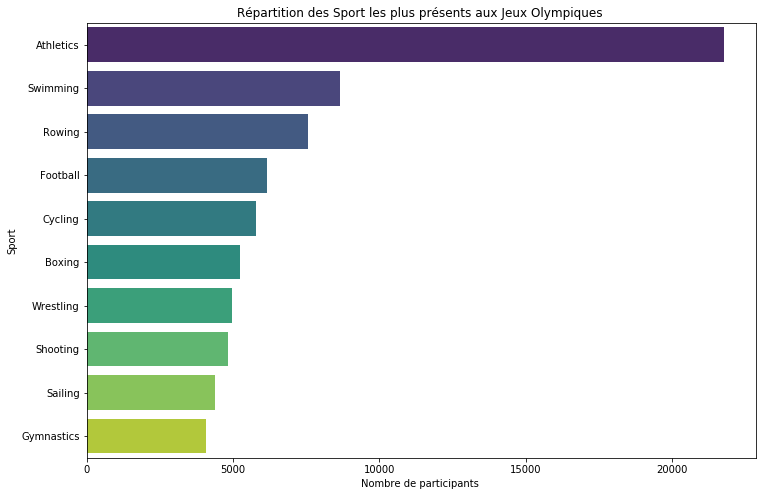

In [252]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un graphique à barres horizontales
plt.figure(figsize=(12, 8))
sns.barplot(x='nombreparticipants', y='sport', data=df, palette='viridis')

# Ajouter des étiquettes et un titre
plt.xlabel("Nombre de participants ")
plt.ylabel('Sport')
plt.title("Répartition des Sport les plus présents aux Jeux Olympiques ")

# Afficher le graphique
plt.show()

### On s'intéresse à présent au nombre de médailles remportées par sports .

- Voici une analyse statistique des médailles remportées dans chaque sport, incluant le nombre total de médailles ainsi que le décompte des médailles d'or, d'argent et de bronze.

In [245]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Sport,
    COUNT(*) AS TotalMedals,
    SUM(CASE WHEN Medal = 'Gold' THEN 1 ELSE 0 END) AS Gold,
    SUM(CASE WHEN Medal = 'Silver' THEN 1 ELSE 0 END) AS Silver,
    SUM(CASE WHEN Medal = 'Bronze' THEN 1 ELSE 0 END) AS Bronze
FROM {table_name}
WHERE Medal IN ('Gold', 'Silver', 'Bronze') 
GROUP BY Sport
ORDER BY TotalMedals DESC
LIMIT 10
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df

,sport,totalmedals,gold,silver,bronze
0,Athletics,3493,1149,1178,1166
1,Rowing,2828,923,944,961
2,Swimming,2785,973,918,894
3,Gymnastics,1915,659,629,627
4,Football,1566,513,511,542
5,Hockey,1518,512,498,508
6,Ice Hockey,1504,505,501,498
7,Sailing,1194,430,405,359
8,Basketball,1058,350,359,349
9,Handball,1057,348,357,352


### Visualisation du classement par sport

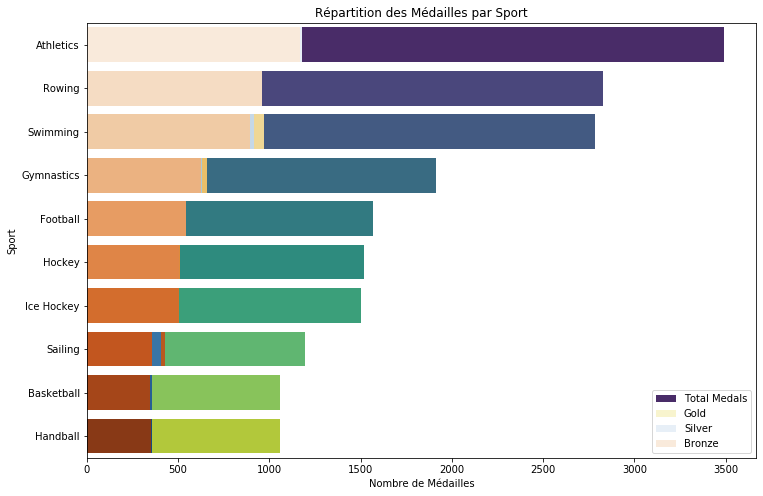

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un graphique à barres horizontales empilées
plt.figure(figsize=(12, 8))
sns.barplot(y='sport', x='totalmedals', data=df, palette='viridis', label='Total Medals')
sns.barplot(y='sport', x='gold', data=df, palette='YlOrBr', label='Gold')
sns.barplot(y='sport', x='silver', data=df, palette='Blues', label='Silver')
sns.barplot(y='sport', x='bronze', data=df, palette='Oranges', label='Bronze')

# Ajouter des étiquettes et un titre
plt.ylabel('Sport')
plt.xlabel('Nombre de Médailles')
plt.title('Répartition des Médailles par Sport')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

### On s'intéresse à présent au nombre de participation pour chaque année aux Jeux olympiques

In [247]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Year,
    COUNT(DISTINCT ID) AS NombreParticipants
FROM
    {table_name}
WHERE Year IS NOT NULL AND ID IS NOT NULL    
GROUP BY Year
ORDER BY Year DESC, NombreParticipants DESC
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df.head()

,year,nombreparticipants
0,2016,11163
1,2014,2741
2,2012,10490
3,2010,2528
4,2008,10869


### Visualisation de l'évolution du nombre de participants au fil du temps

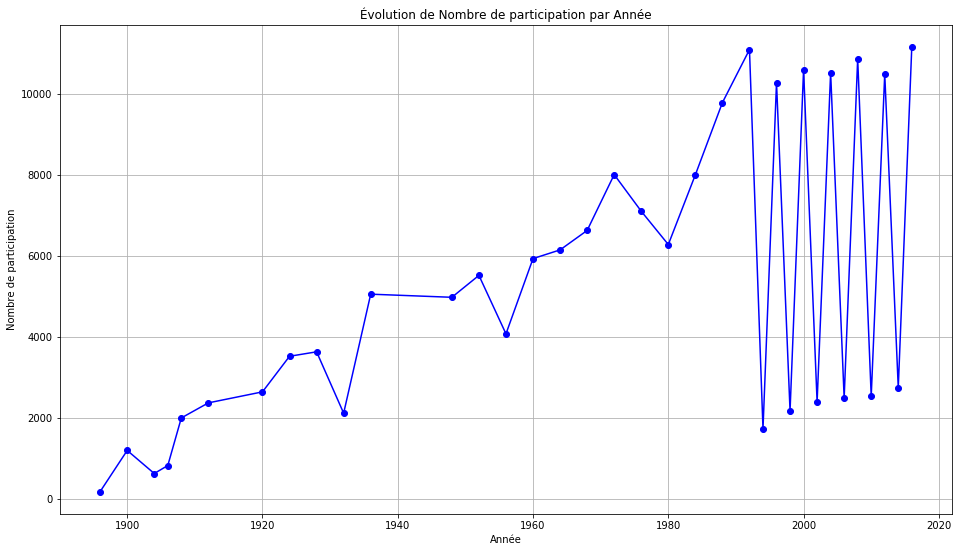

In [248]:
import matplotlib.pyplot as plt


years = df['year'].values
total_medals = df['nombreparticipants'].values

# Création du graphique en ligne
plt.figure(figsize=(16, 9))
plt.plot(years, total_medals, label='Nombre de participation', marker='o', color='blue')

# Ajout des étiquettes et titres
plt.xlabel('Année')
plt.ylabel('Nombre de participation')
plt.title('Évolution de Nombre de participation par Année')

# Affichage du graphique
plt.grid(True)
plt.show()


### On s'intéresse à présent au nombre de médailles remportées par année aux Jeux olympiques.

In [249]:
# Connexion à Hive
conn = hive.Connection(host="projet-biddata-m", port=10000, username="berkani_yacine")

# Requête Hive
hive_query = f"""
SELECT
    Year,
    COUNT(*) AS TotalMedals,
    SUM(CASE WHEN Medal = 'Gold' THEN 1 ELSE 0 END) AS Gold,
    SUM(CASE WHEN Medal = 'Silver' THEN 1 ELSE 0 END) AS Silver,
    SUM(CASE WHEN Medal = 'Bronze' THEN 1 ELSE 0 END) AS Bronze
FROM {table_name}
WHERE Medal IN ('Gold', 'Silver', 'Bronze') 
GROUP BY Year
ORDER BY Year DESC, TotalMedals DESC
"""

# Exécution de la requête
with conn.cursor() as cursor:
    cursor.execute(hive_query)

    # Récupération des résultats
    df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
conn.close()

# Affichage du DataFrame
df.head()

,year,totalmedals,gold,silver,bronze
0,2016,1686,557,549,580
1,2014,556,188,184,184
2,2012,1598,521,521,556
3,2010,476,160,158,158
4,2008,1694,553,555,586


### Visualisation de l'évolution temporelle du nombre total de médailles
La visualisation en ligne avec Matplotlib illustre l'évolution du nombre total de médailles, ainsi que des médailles d'or, d'argent et de bronze, au fil des années lors des Jeux olympiques.

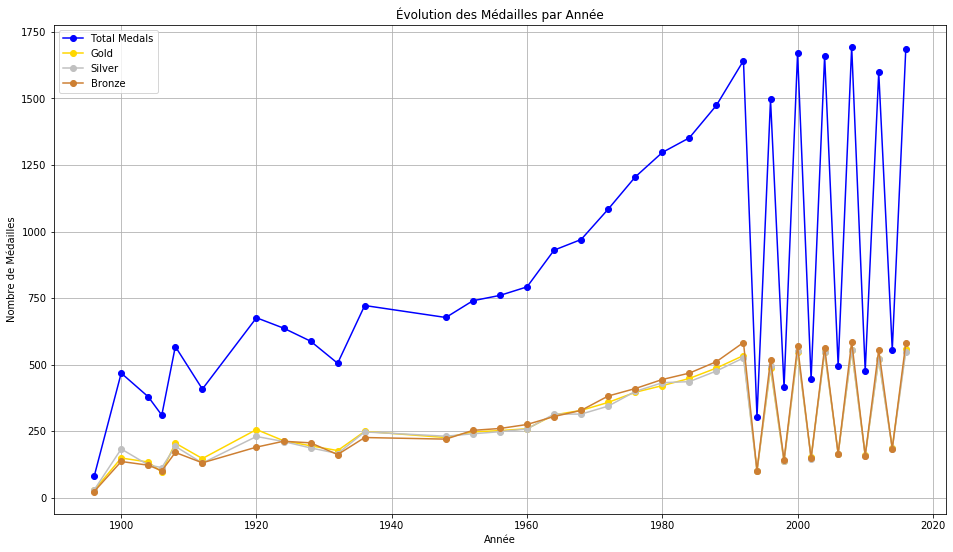

In [250]:
import matplotlib.pyplot as plt


years = df['year'].values
total_medals = df['totalmedals'].values
gold = df['gold'].values
silver = df['silver'].values
bronze = df['bronze'].values

# Création du graphique en ligne
plt.figure(figsize=(16, 9))
plt.plot(years, total_medals, label='Total Medals', marker='o', color='blue')
plt.plot(years, gold, label='Gold', marker='o', color='gold')
plt.plot(years, silver, label='Silver', marker='o', color='silver')
plt.plot(years, bronze, label='Bronze', marker='o', color='#cd7f32')

# Ajout des étiquettes et titres
plt.xlabel('Année')
plt.ylabel('Nombre de Médailles')
plt.title('Évolution des Médailles par Année')
plt.legend()

# Affichage du graphique
plt.grid(True)
plt.show()

# Conclusion

- En conclusion, L'analyse détaillée des données olympiques a révélé des tendances significatives, mettant en lumière des disparités notables entre les sexes en termes de poids et de taille. Les visualisations ont clairement démontré que les hommes présentent généralement des poids et des tailles plus élevés que les femmes. Les classements des pays les plus performants, Les visualisations détaillées par pays soulignent la suprématie de nations majeures telles que les États-Unis et l'Union soviétique, qui ont excellé dans toutes les catégories de médailles, masculines et féminines, tant globalement que par sexe, ont offert une perspective globale de l'excellence olympique. De plus, l'analyse des sports les plus présents a souligné les disciplines les plus populaires aux Jeux olympiques. Les visualisations temporelles ont permis de suivre l'évolution du nombre de participants et du total de médailles au fil des années, offrant ainsi une compréhension approfondie de l'histoire des Jeux olympiques. En conclusion, cette étude exhaustive fournit des insights riches sur la dynamique complexe des performances sportives à travers les éditions des Jeux olympiques